<a href="https://colab.research.google.com/github/LeonardoGoncRibeiro/PersonalProjects/blob/main/EvaluatingCreditScore/CreditScorecard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Scorecard

In this project, we will cover the main steps of building a credit scorecard. These are very important, as they allow companies to understand more about their customers. Most companies use credit scorecards to understand when they are able to provide credit and trust-based benefits to the customers.

A credit scorecard is basically a numerical value (usually an integer) that represents the probability that an individual will pay off a debt. Most companies have complex credit models that consider information such as salary, guarantees, past loan performance, and others.

A credit scorecard is usually related to a customer's "ability to pay". It is often evaluated after the fitting and use of a classification model, which evaluates a certain probability. In our case, we are going to build a model to **evaluate the probability of a given customer paying their debt**. Then, we will **relate this probability to a given score.** This is important, so that we can reveal the score to other people, while revealing a probability might be unethical or even make some people very angry. 

In this project, we will go through the following points:

1. Data collection and cleaning
2. Data exploration
3. Feature selection
4. Model fitting and defining the credit score
5. Final recommendations


Now, let's import our packages:

In [ ]:
import pandas as pd                                           # Data collection and manipulation
import numpy as np                                            # Work with arrays

import matplotlib.pyplot as plt                               # Data visualization
import seaborn as sns                                         # Data visualization
%matplotlib inline

from scipy.stats import mannwhitneyu                          # Mann-whitney test

# Modeling

from sklearn.model_selection import train_test_split          # Train-test split
from sklearn.linear_model import LogisticRegression           # Logistic regression

# Model validation

from sklearn import metrics                                   # Metrics for comparing different models
from sklearn.metrics import confusion_matrix                  # Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay            # Confusion matrix plot

# Data collection and cleaning

In this project, we will use a dataset from a Kaggle competition on the building of a credit score model:

https://www.kaggle.com/competitions/GiveMeSomeCredit/data

Here, we will work with data from the 'cs-training.csv' file:

In [ ]:
df = pd.read_csv('cs-training.csv')

Let's see our dataset:

In [ ]:
df.head( )

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Note that we have a feature "Unnamed: 0" which is basically the index. We can drop this feature. 



In [ ]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

Now, let's talk about the other features:

* SeriousDlqin2yrs: This is our target. This boolean variable states that, in the two previous years, the person experienced financial distress.
* RevolvingUtilizationOfUnsecuredLines: Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits.
* age: Age of borrower in years.
* NumberOfTime30-59DaysPastDueNotWorse: Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
* NumberOfTime60-89DaysPastDueNotWorse: Number of times borrower has been 60-89 days past due but no worse in the last 2 years.
* NumberOfTimes90DaysLate: Number of times borrower has been 90 days or more past due.
* DebtRatio: Monthly debt payments, alimony,living costs divided by monthy gross income
* MonthlyIncome: Monthly income.
* NumberOfOpenCreditLinesAndLoans: Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards).
* NumberRealEstateLoansOrLines: Number of mortgage and real estate loans including home equity lines of credit.
* NumberOfDependents: Number of dependents in family excluding themselves (spouse, children etc.).

First, note that, in our target variable, 1 denotes a bad borrower and 0 denotes a good borrower. Let's invert this, to make the implementation of the credit scorecard more straightfoward:

In [ ]:
df.rename(columns = {'SeriousDlqin2yrs':'NoSeriousDlqin2yrs'}, inplace = True)
df.NoSeriousDlqin2yrs = df.NoSeriousDlqin2yrs.map({1 : 0, 0 : 1})




So, let's clean our dataset. First, we will use the info( ) method to check the number of entries and check if we have any missing value. 

In [ ]:
df.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   NoSeriousDlqin2yrs                    150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

We see that we actually have a lot of missing values, especially in the monthly income feature. First, let's try to check those:

In [ ]:
df[df.MonthlyIncome.isna( )].head(10)

,NoSeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
6,1,0.305682,57,0,5710.0,NaN,8,0,3,0,0.0
8,1,0.116951,27,0,46.0,NaN,2,0,0,0,NaN
16,1,0.061086,78,0,2058.0,NaN,10,0,2,0,0.0
32,1,0.083418,62,0,977.0,NaN,6,0,1,0,0.0
41,1,0.072898,81,0,75.0,NaN,7,0,0,0,0.0
52,1,1.000000,62,0,0.0,NaN,1,0,0,0,0.0
58,1,0.541109,43,0,2477.0,NaN,3,0,1,0,2.0
62,1,0.101156,72,0,1720.0,NaN,12,0,2,0,0.0
71,1,0.142013,67,0,1824.0,NaN,7,0,2,0,0.0
86,1,0.360510,58,1,3282.0,NaN,8,0,2,0,0.0


Actually, note that, in these cases, the DebtRatio (which should be between 0 and 1) is likely displaying the monthly income. Let's understand more about this by plotting a histogram:

(0.0, 10000.0)

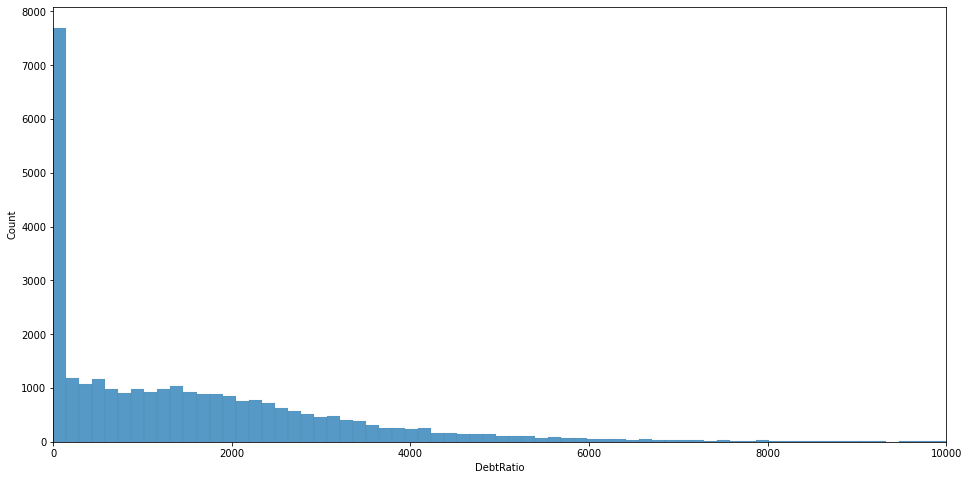

In [ ]:
plt.figure(figsize = (16, 8))

sns.histplot(df[df.MonthlyIncome.isna( )].DebtRatio)

plt.xlim([0, 10000])

Note that, indeed, this seems like a monthly income plot (exponential distribution). Still, we will drop these entries, since we have no information about the debt ratio (which seems to be an important feature). 

In [ ]:
df.drop(df[df.MonthlyIncome.isna( )].index, inplace = True)

Let's check again if we still have any missing values:

In [ ]:
df.info( )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120269 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   NoSeriousDlqin2yrs                    120269 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  120269 non-null  float64
 2   age                                   120269 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  120269 non-null  int64  
 4   DebtRatio                             120269 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       120269 non-null  int64  
 7   NumberOfTimes90DaysLate               120269 non-null  int64  
 8   NumberRealEstateLoansOrLines          120269 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  120269 non-null  int64  
 10  NumberOfDependents                    120269 non-null  float64
dtype

Ok, it seems that we have no missing value. Now, let's see if we have any duplicated entries:

In [ ]:
df.duplicated( ).sum( )

99

We have 99 duplicated entries. Let's drop those:

In [ ]:
df.drop_duplicates(inplace = True)

Great! Now, let's just reset the index:

In [ ]:
df.reset_index(drop = True, inplace = True)

In [ ]:
df

,NoSeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,1,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,1,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,1,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
120165,1,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
120166,1,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
120167,1,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
120168,1,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


Nice! It seems that our data is ok now. Let's try to understand more about our features, to see if that is something fishy about our data that we could not get by our initial analysis.

# Data Exploration

Now, let's explore our data. First, let's see how unbalanced is our dataset:

In [ ]:
def plot_perc(feature, dataset):
  plt.figure(figsize = (16, 6))
  g = sns.countplot(x = feature, data = dataset, orient = 'h')

  g.set_ylabel('Count', fontsize = 18)

  sizes = []
  for p in g.patches:
    height = p.get_height( )
    sizes.append(height)
    g.text(p.get_x( ) + p.get_width( )*0.2, 
           height, 
           '{:1.2f}%'.format(height/len(dataset)*100),
           ha = 'center', va = 'bottom', fontsize = 12)
    
  g.set_ylim(0, max(sizes)*1.1)

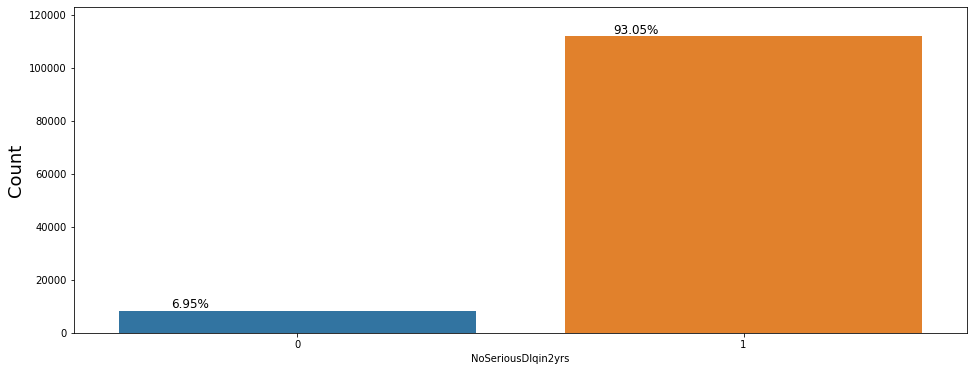

In [ ]:
plot_perc('NoSeriousDlqin2yrs', df)

So, in our dataset, only 6.95% of the entries are negatives, while 93.05% are positives. So, our dataset is **very** unbalanced. We will likely have to do something to balance our data, so that we are able to identify the negatives in our set.

Now, let's try to understand more about some of our features. 

## Age

First, let's see how is the age distribution in our set:

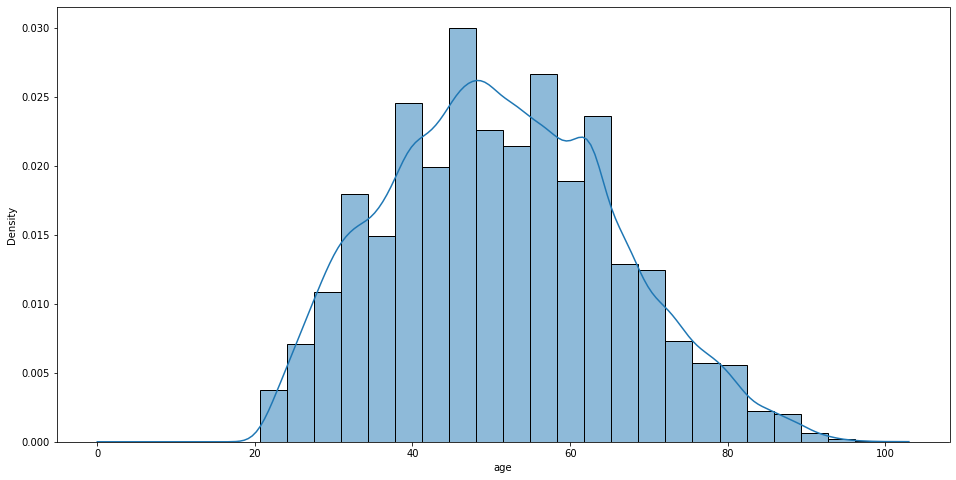

In [ ]:
plt.figure(figsize = (16, 8))

sns.histplot(df.age, bins = 30, stat = 'density', kde = True)

For some reason, our age distribution seems to have some spikes. Let's try to draw a boxplot for the age, and understand if the age influences in our target:

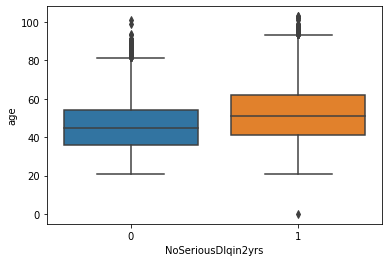

In [ ]:
sns.boxplot(x = 'NoSeriousDlqin2yrs', y = 'age', data = df)

It seems that younger people are slightly more likely to experience financial distress. We can check this hypothesis using a Mann-Whitney test:

\begin{equation}
H_0 : \text{Group 0 does not present lower values ($\mu_0 \geq \mu_1$).}
\end{equation}

\begin{equation}
H_1 : \text{Group 0 usually presents lower values ($\mu_0 < \mu_1$).}
\end{equation}

In [ ]:
df_0 = df.query("NoSeriousDlqin2yrs == 0")
df_1 = df.query("NoSeriousDlqin2yrs == 1")

mannwhitneyu(df_0.age, df_1.age, alternative = 'less')

MannwhitneyuResult(statistic=356610979.5, pvalue=3.448977896553105e-286)

Since our p-value is very low, we can reject the null hypothesis, and accept the alternative hypothesis (younger people are more likely to experience financial distress).

Also, note that, by the boxplot, we can see that we have some entries with age = 0. This is likely a misplaced entry. Let's drop those:

In [ ]:
df.drop(df.query("age == 0").index, inplace = True)

## Number of times past due

Now, let's us a bar plot to get how the number of times the person got a 30-59 days past due (but not worse):

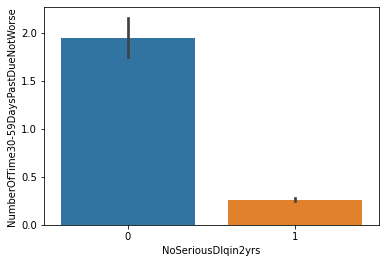

In [ ]:
sns.barplot(x = 'NoSeriousDlqin2yrs', y = 'NumberOfTime30-59DaysPastDueNotWorse', data = df)

So, the mean number of times the person got a 30-59 days past due (but not worse) seems to be highly related to the target. Now, let's do a similar plot, now for the number of times the person got a 60-89 days past due (but not worse):

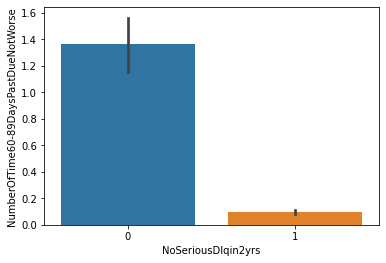

In [ ]:
sns.barplot(x = 'NoSeriousDlqin2yrs', y = 'NumberOfTime60-89DaysPastDueNotWorse', data = df)

Again, highly related to the target. Also, so does the number of 90 days late:

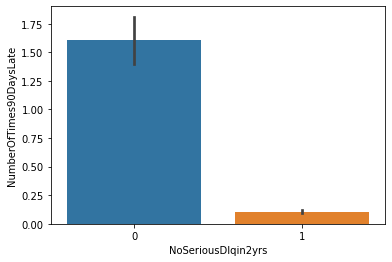

In [ ]:
sns.barplot(x = 'NoSeriousDlqin2yrs', y = 'NumberOfTimes90DaysLate', data = df)

## Monthly Income

Now, let's try to understand how the monthly income affects the target:

(0.0, 20000.0)

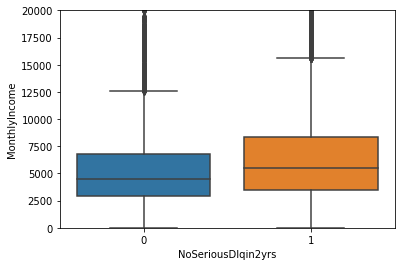

In [ ]:
sns.boxplot(x = 'NoSeriousDlqin2yrs', y = 'MonthlyIncome', data = df)
plt.ylim([0, 20000])

So, it seems that a lower income is related to a higher probability of financial distress. We can check this again using a test:

\begin{equation}
H_0 : \text{Group 0 does not present lower values ($\mu_0 \geq \mu_1$).}
\end{equation}

\begin{equation}
H_1 : \text{Group 0 usually presents lower values ($\mu_0 < \mu_1$).}
\end{equation}

In [ ]:
mannwhitneyu(df_0.MonthlyIncome, df_1.MonthlyIncome, alternative = 'less')

MannwhitneyuResult(statistic=395718967.5, pvalue=8.684035037066852e-121)

Again, since the p-value is lower than 0.05, we can reject the null hypothesis, and consider that a lower income is related to a higher probability of financial distress. 

## Debt Ratio and Revolving Utilization of Unsecured Lines

Let's try to understand more about our debt ratio and revolving utilization of unsecured lines features. Note that these features express percentages and, as such, should be between 0 and 1. First, for debt ratio:

In [ ]:
df.DebtRatio.describe( )

count    120169.000000
mean         26.620898
std         424.622333
min           0.000000
25%           0.143842
50%           0.296171
75%           0.482710
max       61106.500000
Name: DebtRatio, dtype: float64

Our maximum value is 61106, and our mean value is 26.59. That is very strange, since the debt ratio should be between 0 and 1. It seems that this feature is not representing the true data. 

Now, let's use a similar method for the Revolving Utilization of Unsecured Lines:

In [ ]:
df.RevolvingUtilizationOfUnsecuredLines.describe( )

count    120169.000000
mean          5.904324
std         257.147566
min           0.000000
25%           0.035149
50%           0.177257
75%           0.578850
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

Again, a similar problem. Let's try to understand the number of incorrectly placed entries. Here, we will consider that the wrongfully placed entries are those higher than 5.0 (maybe someone actually has a debt ratio higher than 1.0, but it should not be that much higher).

In [ ]:
n_wrong_debtratio = df.query("DebtRatio > 5.0").shape[0]
n_wrong_unsecured = df.query("RevolvingUtilizationOfUnsecuredLines > 5.0").shape[0]

print("Number of entries higher than 5.0:")
print(f"Debt ratio: {n_wrong_debtratio}")
print(f"Revolving utilization of unsecured lines: {n_wrong_unsecured}")

Number of entries higher than 5.0:
Debt ratio: 2352
Revolving utilization of unsecured lines: 182


So, it seems that a large part of our dataset has a wrongfully placed debt ratio. However, very few entries have a wrongfully placed revolving utilization of unsecured lines. Here, we will:

*   Drop the debt ratio feature.
*   Drop the entries with a wrongfully placed revolving utilization of unsecured lines.



In [ ]:
# Dropping debt ratio

drop_features = ['DebtRatio']
df.drop(drop_features, axis = 1, inplace = True)

# Dropping wrong entries (for RevolvingUtilizationOfUnsecuredLines)

df.drop(df.query("RevolvingUtilizationOfUnsecuredLines > 5.0").index, inplace = True)

## Number of open credit lines and loans and number of real estate loans of lines

Now, let's see how the number of credit lines affect our target. Here, again, we will analyze using boxplots:

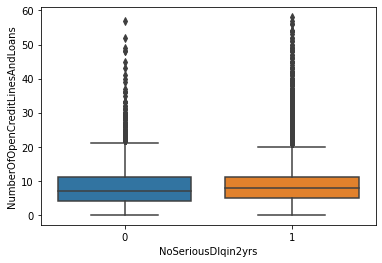

In [ ]:
sns.boxplot(x = 'NoSeriousDlqin2yrs', y = 'NumberOfOpenCreditLinesAndLoans', data = df)

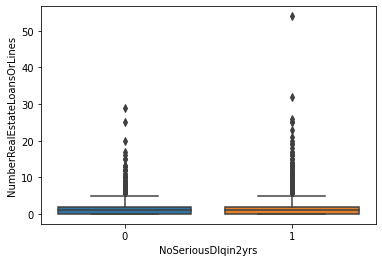

In [ ]:
sns.boxplot(x = 'NoSeriousDlqin2yrs', y = 'NumberRealEstateLoansOrLines', data = df)

Note that, actually, people in financial distress seem to have fewer open credit lines/real estate loans. Once again, let's use a test to confirm this hypothesis:

\begin{equation}
H_0 : \text{Group 1 does not present lower values ($\mu_1 \geq \mu_0$).}
\end{equation}

\begin{equation}
H_1 : \text{Group 1 usually presents lower values ($\mu_1 < \mu_0$).}
\end{equation}

In [ ]:
mannwhitneyu(df_0.NumberOfOpenCreditLinesAndLoans, df_1.NumberOfOpenCreditLinesAndLoans, alternative = 'less')

MannwhitneyuResult(statistic=429446737.5, pvalue=2.7376223749181453e-35)

In [ ]:
mannwhitneyu(df_0.NumberRealEstateLoansOrLines, df_1.NumberRealEstateLoansOrLines, alternative = 'less')

MannwhitneyuResult(statistic=435872429.0, pvalue=2.5836441221079157e-27)

Again, since our p-values are lower than the test significance (considered here to be 0.05), we reject the null hypothesis. 

## Number of dependents

Now, let's go to our final variable, related to the number of dependents. Here, we will do an analysis very similar to the previous one. Let's plot a boxplot:

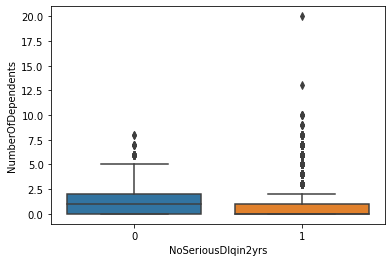

In [ ]:
sns.boxplot(x = 'NoSeriousDlqin2yrs', y = 'NumberOfDependents', data = df)

Here, it seems that, as someone has more dependents, they are more likely to be in financial distress. At the same time, there are some people (outliers) who have a lot of dependents and are not in financial distress. Let's make a test:

\begin{equation}
H_0 : \text{Group 0 does not present greater values ($\mu_0 \leq \mu_1$).}
\end{equation}

\begin{equation}
H_1 : \text{Group 0 usually presents greater values ($\mu_0 > \mu_1$).}
\end{equation}

In [ ]:
mannwhitneyu(df_0.NumberOfDependents, df_1.NumberOfDependents, alternative = 'greater')

MannwhitneyuResult(statistic=512379400.0, pvalue=7.259093784964209e-60)

Again, a p-value lower than 0.05. So, we reject the null hypothesis.

## Correlation between features

Finally, let's check the correlation between our features:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


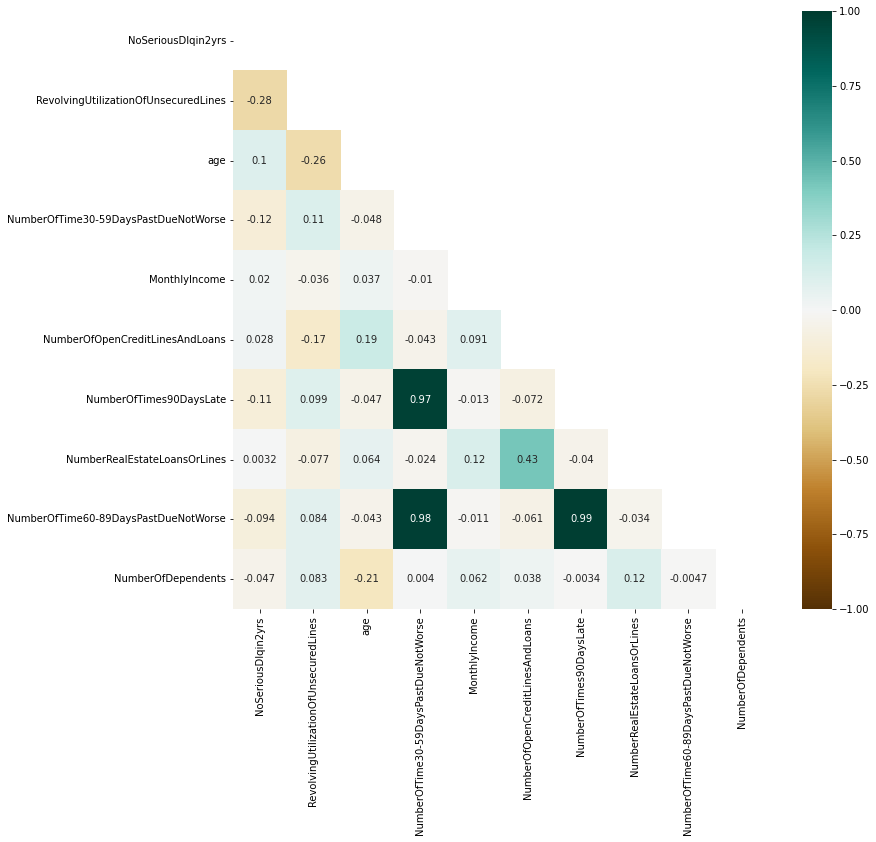

In [ ]:
plt.figure(figsize=(12, 11))

mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

Note that there is a very high correlation between the features related to debts 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', and 'NumberOfTimes90DaysLate'. Here, we should drop two of those. Besides those features, no other feature presents a particularly high correlation with another feature.

So, instead of dropping the features, we will actually create a new feature, name 'NumberOfTimes30DaysLate'. This feature will basically be the sum between those three highly correlated features. Thus, let's try to do it:

In [ ]:
df['NumberOfTimes30DaysLate'] = df['NumberOfTime30-59DaysPastDueNotWorse'] + df['NumberOfTime60-89DaysPastDueNotWorse'] + df['NumberOfTimes90DaysLate']

Now, let's drop our features:

In [ ]:
drop_features = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']

df.drop(drop_features, axis = 1, inplace = True)

Ok, so we end up with the following dataset:

In [ ]:
df.head( )

,NoSeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,NumberOfTimes30DaysLate
0,0,0.766127,45,9120.0,13,6,2.0,2
1,1,0.957151,40,2600.0,4,0,1.0,0
2,1,0.658180,38,3042.0,2,0,0.0,2
3,1,0.233810,30,3300.0,5,0,0.0,0
4,1,0.907239,49,63588.0,7,1,0.0,1


Let's just check once again the correlation between features:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


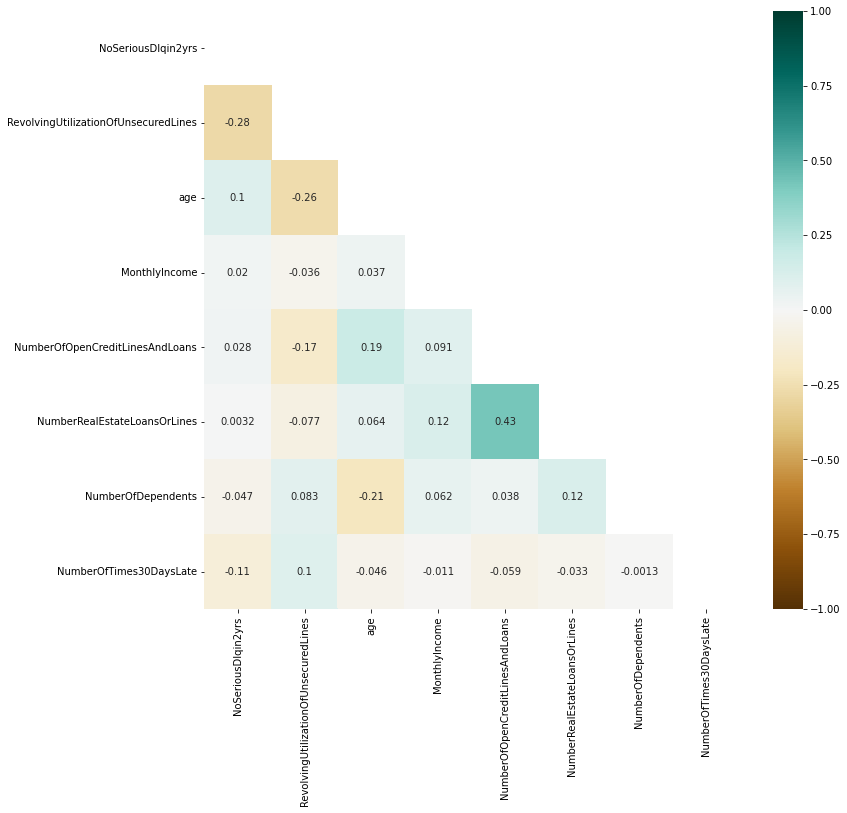

In [ ]:
plt.figure(figsize=(12, 11))

mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

Nice! Now, let's continue to feature selection.

# Feature selection

In this project, we will perform feature selection so that our model only considers the best features in our dataset. Thus, here, we will analyze the Information Value (IV) of each feature, evaluated using the Weight of Evidence (WoE). In this method, we will first define groups for our features. Then, we evaluate the percentage of people in each group running financial distress. Finally, we transform the feature based on this percentage, and we replace the raw data with the calculated WoE.

The WoE is defined by:

\begin{equation}
\text{WoE: } \ln\left( \dfrac{\% \text{Good}}{\% \text{Bad}} \right)
\end{equation}

where $\% \text{Good}$ and $\% \text{Bad}$ are the relative number of entries in the group which are from the "Good" and "Bad" classes, respectively. Then, the Information Value is given by:

\begin{equation}
\text{IV: } \sum_{i = 1}^n ( \% \text{Good}_i - \% \text{Bad}_i) \times \text{WoE}
\end{equation}
where the subscript $i$ refers to the $i$-th group.

So, let's try to do this with age. First,we can use the describe( ) method to understand more about our feature:

In [ ]:
df.age.describe( )

count    119987.000000
mean         51.317701
std          14.410277
min          21.000000
25%          41.000000
50%          51.000000
75%          61.000000
max         103.000000
Name: age, dtype: float64

The minimum value is 21 and the highest value is 103. So, let's separe our data into some bins:

In [ ]:
bins = [18, 24, 30, 35, 40, 45, 50, 60, 70, 80, 1e6]

Nice! Now, let's create and auxiliary data frame and define out groups for age:

In [ ]:
df['age_group'] = pd.cut(df.age, bins, include_lowest=True)

In [ ]:
df[['age','age_group']].sample(10)

,age,age_group
99401,62,"(60.0, 70.0]"
41328,43,"(40.0, 45.0]"
46293,68,"(60.0, 70.0]"
56958,34,"(30.0, 35.0]"
61042,52,"(50.0, 60.0]"
47195,27,"(24.0, 30.0]"
109735,35,"(30.0, 35.0]"
4757,59,"(50.0, 60.0]"
105332,58,"(50.0, 60.0]"
38209,24,"(17.999, 24.0]"


Nice! Our bins seem to have worked. Now, let's count how many entries we have in each bin, as well as how many entries are "Positives" (good borrowers) and how many entries are "Negatives" (bad borrowers):

In [ ]:
df_age_group = pd.DataFrame( )

df_age_group['counts'] = df.groupby('age_group')['age'].count( )
df_age_group['good']   = df.query("NoSeriousDlqin2yrs == 1").groupby('age_group')['age'].count( )
df_age_group['bad']    = df.query("NoSeriousDlqin2yrs == 0").groupby('age_group')['age'].count( )

df_age_group.reset_index(inplace = True)

In [ ]:
df_age_group

,age_group,counts,good,bad
0,"(17.999, 24.0]",1540,1388,152
1,"(24.0, 30.0]",7406,6556,850
2,"(30.0, 35.0]",9314,8356,958
3,"(35.0, 40.0]",11662,10601,1061
4,"(40.0, 45.0]",13805,12636,1169
5,"(45.0, 50.0]",15718,14434,1284
6,"(50.0, 60.0]",27863,26082,1781
7,"(60.0, 70.0]",20451,19689,762
8,"(70.0, 80.0]",9122,8877,245
9,"(80.0, 1000000.0]",3106,3031,75


Great! Now, let's the the percentage from the total each class represents:

In [ ]:
df_age_group['counts_perc'] = df_age_group.counts/sum(df_age_group.counts)
df_age_group['good_perc']   = df_age_group.good/sum(df_age_group.good)
df_age_group['bad_perc']    = df_age_group.bad/sum(df_age_group.bad)

In [ ]:
df_age_group

,age_group,counts,good,bad,counts_perc,good_perc,bad_perc
0,"(17.999, 24.0]",1540,1388,152,0.012835,0.012432,0.018232
1,"(24.0, 30.0]",7406,6556,850,0.061723,0.058719,0.101955
2,"(30.0, 35.0]",9314,8356,958,0.077625,0.074841,0.114909
3,"(35.0, 40.0]",11662,10601,1061,0.097194,0.094948,0.127264
4,"(40.0, 45.0]",13805,12636,1169,0.115054,0.113175,0.140218
5,"(45.0, 50.0]",15718,14434,1284,0.130998,0.129279,0.154012
6,"(50.0, 60.0]",27863,26082,1781,0.232217,0.233605,0.213626
7,"(60.0, 70.0]",20451,19689,762,0.170443,0.176346,0.091400
8,"(70.0, 80.0]",9122,8877,245,0.076025,0.079507,0.029387
9,"(80.0, 1000000.0]",3106,3031,75,0.025886,0.027147,0.008996


Now, we can calculate the WoE by:

In [ ]:
df_age_group['WoE'] = np.log(df_age_group.good_perc / df_age_group.bad_perc).round(4)

Now, we can evaluate the IV for age by:

In [ ]:
IV = sum((df_age_group.good_perc - df_age_group.bad_perc) * df_age_group.WoE)

print(f"IV (age): {IV}")

IV (age): 0.19039665919760193


To judge the IV value, we can consider that:

* IV < 0.02: Not useful.
* 0.02 < IV < 0.10: Weak predictive power.
* 0.10 < IV < 0.30: Medium predictive power.
* 0.30 < IV < 0.50: Strong predictive power.
* 0.50 < IV: Suspicious predictive power.

So, the age feature has a medium predictive power. Thus, we will leave this feature in our dataset. Also, we will need the WoE for each group later. So, let's store it in a dataframe:

In [ ]:
df_woe = df_age_group[['age_group', 'WoE']].copy( )
df_woe.columns = ['group', 'WoE']
df_woe['feature'] = 'age'

df_woe = df_woe[['feature', 'group', 'WoE']]

In [ ]:
df_woe

,feature,group,WoE
0,age,"(17.999, 24.0]",-0.3829
1,age,"(24.0, 30.0]",-0.5518
2,age,"(30.0, 35.0]",-0.4288
3,age,"(35.0, 40.0]",-0.2929
4,age,"(40.0, 45.0]",-0.2143
5,age,"(45.0, 50.0]",-0.1751
6,age,"(50.0, 60.0]",0.0894
7,age,"(60.0, 70.0]",0.6572
8,age,"(70.0, 80.0]",0.9953
9,age,"(80.0, 1000000.0]",1.1045


The higher the WoE, the higher the good/bad ratio. For negative WoE's, the bad customer ratio is higher than the good customer ratio. Now, to finish everything, let's replace the group name in the main dataframe with the WoE value from each group. We can do that using:

In [ ]:
tmp_dict = 	pd.Series(df_woe.query("feature == 'age'").WoE.values,index=df_woe.query("feature == 'age'").group).to_dict( )

df['age_group'] = df['age_group'].map(tmp_dict)

Finally, let's create a user-defined function to get the IV for a given feature (as well as update the rest of the dataframes):

In [ ]:
def GetIV(feature, feature_bins, data, group_name, df_WoE):
  data[group_name] = pd.cut(df[feature], feature_bins, include_lowest=True)

  df_group = pd.DataFrame( )

  df_group['counts']      = data.groupby(group_name)[feature].count( )
  df_group['good']        = data.query("NoSeriousDlqin2yrs == 1").groupby(group_name)[feature].count( )
  df_group['bad']         = data.query("NoSeriousDlqin2yrs == 0").groupby(group_name)[feature].count( )
  df_group['counts_perc'] = df_group.counts/sum(df_group.counts)
  df_group['good_perc']   = df_group.good/sum(df_group.good)
  df_group['bad_perc']    = df_group.bad/sum(df_group.bad)

  df_group['WoE'] = np.log(df_group.good_perc / df_group.bad_perc).round(4)

  df_group = df_group.reset_index( ).rename(columns={df_group.index.name:'group'})

  df_group_WoE = df_group[['group', 'WoE']].copy( )
  df_group_WoE['feature'] = feature

  df_group_WoE = df_group_WoE[['feature', 'group', 'WoE']]

  df_WoE = pd.concat([df_WoE, df_group_WoE])

  IV = sum((df_group.good_perc - df_group.bad_perc) * df_group.WoE)

  tmp_dict = 	pd.Series(df_group_WoE.WoE.values,index=df_group_WoE.group).to_dict( )

  df[group_name] = df[group_name].map(tmp_dict)

  return IV, df_WoE

Nice! Now, let's get the IV for the other features. First, let's get the IV for RevolvingUtilizationOfUnsecuredLines. We will use a describe to understand more about the feature:

In [ ]:
df.RevolvingUtilizationOfUnsecuredLines.describe( )

count    119987.000000
mean          0.332974
std           0.359650
min           0.000000
25%           0.035013
50%           0.176562
75%           0.575898
max           4.937063
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

So, we will create a list of bins, and apply the function to get the IV:

In [ ]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1e6]
IV, df_woe = GetIV('RevolvingUtilizationOfUnsecuredLines', bins, df, 'revolv_group', df_woe)
print(f"IV: {IV}")

IV: 1.054539156146092


Nice! This feature actually seems to have a very high predictive power. Now, Monthly Income:

In [ ]:
df.MonthlyIncome.describe( )

count    1.199870e+05
mean     6.672385e+03
std      1.439803e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [ ]:
bins = [0, 1000, 2000, 3000, 4000, 5000, 7000, 8500, 10000, 12000, 14000, 20000, 1e10]
IV, df_woe = GetIV('MonthlyIncome', bins, df, 'income_group', df_woe)
print(f"IV: {IV}")

IV: 0.09301228792597713


Monthly income actually presents a weak predictive power. Still, we will not drop it from our dataframe. Let's continue:

In [ ]:
df.NumberOfOpenCreditLinesAndLoans.describe( )

count    119987.000000
mean          8.768717
std           5.171798
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [ ]:
bins = [0, 2, 4, 6, 8, 10, 12, 15, 20, 1e6]
IV, df_woe = GetIV('NumberOfOpenCreditLinesAndLoans', bins, df, 'opencredit_group', df_woe)
print(f"IV: {IV}")

IV: 0.06960112053793509


Only IV = 0.0683, again a weak predictive power. Again, since this is at least some predictive power, we will leave this feature on our dataset.


In [ ]:
df.NumberRealEstateLoansOrLines.describe( )

count    119987.000000
mean          1.055081
std           1.149367
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

In [ ]:
bins = [0, 1, 2, 3, 5, 10, 1e6]
IV, df_woe = GetIV('NumberRealEstateLoansOrLines', bins, df, 'numloans_group', df_woe)
print(f"IV: {IV}")

IV: 0.024761519787719732


This feature actually shows IV very close to 0.02. Still, since it was not lower than 0.02, we will keep it. Now, let's go to the number of dependents:

In [ ]:
df.NumberOfDependents.describe( )

count    119987.000000
mean          0.852509
std           1.148678
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [ ]:
bins = [0, 1, 2, 3, 4, 1e6]
IV, df_woe = GetIV('NumberOfDependents', bins, df, 'dependents_group', df_woe)
print(f"IV: {IV}")

IV: 0.0250658709209954


Again, a weak predictive power. Now, to the final feature:


In [ ]:
df.NumberOfTimes30DaysLate.describe( )

count    119987.000000
mean          0.775309
std          10.255766
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         294.000000
Name: NumberOfTimes30DaysLate, dtype: float64

Most of our entries have a 0 value in this feature. To understand more about the feature, let's use a value_counts( ) method:

In [ ]:
df.NumberOfTimes30DaysLate.value_counts( ).sort_index( )

0      94586
1      14435
2       5035
3       2421
4       1320
5        802
6        497
7        309
8        163
9        105
10        62
11        44
12        18
13        17
14        11
15         7
16         4
17         4
18         1
19         1
288        4
294      141
Name: NumberOfTimes30DaysLate, dtype: int64

Now, we can create the bins and evaluate the IV:

In [ ]:
bins = [0, 1, 2, 3, 4, 5, 6, 8, 10, 15, 1e6]
IV, df_woe = GetIV('NumberOfTimes30DaysLate', bins, df, '30dayslate_group', df_woe)
print(f"IV: {IV}")

IV: 1.085400206823606


Again, this feature has a very high information value!

So, we have evaluated the IVs, and we also built our dataframe containing the WoE values for each class, substituting the classes by their WoE's in the main dataframe. Now, let's continue to model fitting and derivation of our credit score.

# Model fitting and defining the credit score

The credit score for each user is related to the probability of the user paying of his debt. To evaluate this probability, we will use a Logistic Regression model. The score for each group (from each feature) can be defined by:

\begin{equation}
\text{Score}_{i, j} = (\beta_i \times \text{WoE}_{i,j} + \alpha/n) \times \text{Factor} + \text{Offset}/n
\end{equation}

where $\beta_i$ is the $i$-th coefficient for the logistic regression, $\alpha$ is the intercept, $n$ is the number of features, and $\text{WoE}_{i,j}$ is the WoE for the $j$-th group of the $i$-th feature. Factor and Offset are scalling parameters, and will be discussed later. Then, to get the final score, we will sum the scores for all features.

So, first, let's fit a logistic regression:

In [ ]:
# Selecting features
features = ['age_group', 'revolv_group', 'income_group', 'opencredit_group', 'numloans_group', 'dependents_group', '30dayslate_group']

# Selecting independent features and target variable
X = df[features]
y = df.NoSeriousDlqin2yrs

# Spliting into train and test sets
SEED = 1001
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

# Evaluating sample weight (to deal with unbalanced data)
n_0 = y_train[y_train == 0].shape[0]
n_1 = y_train[y_train == 1].shape[0]
w = n_1/n_0

# Instance the logistic regression object
LogReg = LogisticRegression(max_iter = 100, class_weight = {0 : w, 1 : 1}, fit_intercept = True, solver = 'lbfgs', random_state = SEED)

# Model fitting
LogReg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 13.363160257369445, 1: 1},
                   random_state=1001)

Nice! Let's see how well our model is doing. First, let's get the confusion matrix:

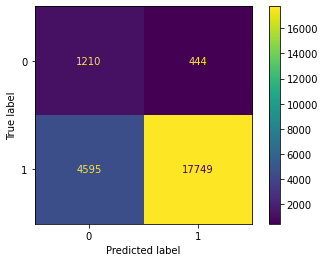

In [ ]:
y_pred = LogReg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(values_format = 'd')

So, we have 1210 True Negatives (our model recognized that those are bad borrowers), 17749 True Positives (our model recognized that those are good borrowers), 444 False Positives (our model was not able to recognize that these are bad borrowers), and 4595 False Negatives (our model was not able to recognize that those are good borrowers).

Now, we can evaluate the accuracy, precision, recall, and f1-score:

In [ ]:
acc = round(metrics.accuracy_score(y_test, y_pred), 4)
prc = round(metrics.precision_score(y_test, y_pred, pos_label = 0), 4)
rec = round(metrics.recall_score(y_test, y_pred, pos_label = 0), 4)
f1s = round(metrics.f1_score(y_test, y_pred, pos_label = 0), 4)

print(f"Accuracy  : {acc}")
print(f"Precision : {prc}")
print(f"Recall    : {rec}")
print(f"F1        : {f1s}")

Accuracy  : 0.79
Precision : 0.2084
Recall    : 0.7316
F1        : 0.3244


Thus, we have a recall of 73.16% and an accuracy of 20.84%. It seems that our model is fine at finding bad borrowers. However, it is conservative in the sense that many good borrowers are mistaken for bad borrowers. Since we lose a lot of money lending to a bad borrower, we may be more interested in identifying bad borrowers, and less concerned with misjudging good borrowers.

Now, let's return to the function and get the parameters necessary for our score. First, $\beta_i$ and $\alpha$ are the logistic regression coefficient for the $i$-th variable and the logistic regression intercept. We will start with the parameters for the age group, so:

In [ ]:
beta_i = LogReg.coef_[0][0]
alpha  = LogReg.intercept_[0]

$n$ is the number of features in our dataset. Thus:

In [ ]:
n = 7

Now, Factor and Offset are scalling parameters:

\begin{equation}
\text{Factor: } \dfrac{\text{pdo}}{\ln2}
\end{equation}

\begin{equation}
\text{Offset: } \text{Target Score} - \text{Factor} \times \ln(\text{Target Odds})
\end{equation}

So, Factor is given by pdo divided by $\ln2$, where pdo is an arbitrary number where an increase in pdo units means a doubling odds. For instance, if pdo = 20, an increase of 20 in a credit score means a doubling odds of paying.

Offset is found by the Target Score (which is also arbitrary) and the target odds (again, arbitrary). For instance, if the Target Score is 600 and the Target Odds is 50, it means that the target score means a 50 to 1 odds of good customer to bad in that group.

Now, let's set our arbitrary variables:

In [ ]:
pdo = 50
factor = pdo/np.log(2)
target_score = 800
target_odds  = 9
offset = target_score - factor*np.log(target_odds)

Great! Finally, let's get the Score for each group for the age feature:

In [ ]:
df_woe.loc[df_woe.feature == 'age', 'score'] = df_woe[df_woe.feature == 'age'].WoE.apply(lambda x : (beta_i * x + alpha/n)*factor + offset/n)

In [ ]:
df_woe.query("feature == 'age'")

,feature,group,WoE,score
0,age,"(17.999, 24.0]",-0.3829,79.636419
1,age,"(24.0, 30.0]",-0.5518,74.449875
2,age,"(30.0, 35.0]",-0.4288,78.226932
3,age,"(35.0, 40.0]",-0.2929,82.400120
4,age,"(40.0, 45.0]",-0.2143,84.813751
5,age,"(45.0, 50.0]",-0.1751,86.017496
6,age,"(50.0, 60.0]",0.0894,94.139704
7,age,"(60.0, 70.0]",0.6572,111.575583
8,age,"(70.0, 80.0]",0.9953,121.957884
9,age,"(80.0, 1000000.0]",1.1045,125.311173


Nice! Now, let's define a function to get the score for all other features:

In [ ]:
def SetScore(params, df_woe, feature):
  beta_i, alpha, n, factor, offset = params['beta_i'], params['alpha'], params['n'], params['Factor'], params['Offset']
  df_woe.loc[df_woe.feature == feature, 'score'] = df_woe[df_woe.feature == feature].WoE.apply(lambda x : (beta_i * x + alpha/n)*factor + offset/n)

To ease things out, let's define a dictionary with our parameters:

In [ ]:
params = {'beta_i' : beta_i,
          'alpha'  : alpha,
          'n'      : n,
          'Factor' : factor,
          'Offset' : offset}

Note that the $\beta_i$ and $\alpha$ parameters will change for different features, as it depends on the fitted logistic regression.

Finally, let's run the method to the other features:

In [ ]:
feature_names = ['age', 'RevolvingUtilizationOfUnsecuredLines', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 
                 'NumberRealEstateLoansOrLines', 'NumberOfDependents', 'NumberOfTimes30DaysLate']

for i in range(len(feature_names)):
  params['beta_i'] = LogReg.coef_[0][i]
  feature = feature_names[i]
  SetScore(params, df_woe, feature)

## Evaluating the credit score for our customers

Nice! Finally, let's get our initial dataframe, and let's try to evaluate the credit score of each of our customers. We basically have to get the score related to each group, and sum them up. 

First, let's get the score for each feature:

In [ ]:
def GetScoreEachFeature(df, feature_names, group_names):
  for i in range(len(feature_names)):
    group   = group_names[i]
    feature = feature_names[i]

    df[feature + '_score'] = df[group] 

    df_woe_group = df_woe[df_woe.feature == feature]
    tmp_dict = 	pd.Series(df_woe_group.score.values,index=df_woe_group.WoE).to_dict( )

    df[feature + '_score'] = df[feature + '_score'].map(tmp_dict)

In [ ]:
group_names = ['age_group', 'revolv_group', 'income_group', 'opencredit_group', 'numloans_group', 'dependents_group', '30dayslate_group']

GetScoreEachFeature(df, feature_names, group_names)

Now, to get the total score, we simply sum the scores from all features:

In [ ]:
def GetTotalScore(df, feature_names):
  feature_score_names = []
  for feature in feature_names:
    feature_score_names.append(feature + '_score')

  df['score'] = df.loc[:, feature_score_names].sum(axis = 1).astype(int)

In [ ]:
GetTotalScore(df, feature_names)

Nice! The credit score is usually an integer, which makes it more easy for the end-user to understand it. Let's see how our scores are distributed using a describe( ):

In [ ]:
df.score.describe( )

count    119987.000000
mean        685.649229
std          83.396828
min         294.000000
25%         644.000000
50%         713.000000
75%         745.000000
max         806.000000
Name: score, dtype: float64

Nice! So, our scores go from 294 to 806. However, most of our scores are higher than 640. Let's see a boxplot to understand more about the distribution of scores depending on the target feature:







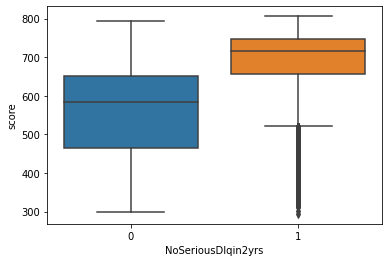

In [ ]:
sns.boxplot(x = 'NoSeriousDlqin2yrs', y = 'score', data = df)

So, our good customers usually show a higher score, and our bad customers usually show a lower score. Note that, however, there are some good customers with bad score, and some bad customers with good score. This is likely due to the false positives and the false negatives from our model.

## Discussing the results

So, we have defined a credit scorecard for our customers. An advantage of the methodology we used is that we can very easily get the score for each group. These are stored in the ```df_woe``` dataframe. For instance, let's see the scores for age:

In [ ]:
df_woe.query("feature == 'age'")

,feature,group,WoE,score
0,age,"(17.999, 24.0]",-0.3829,79.636419
1,age,"(24.0, 30.0]",-0.5518,74.449875
2,age,"(30.0, 35.0]",-0.4288,78.226932
3,age,"(35.0, 40.0]",-0.2929,82.400120
4,age,"(40.0, 45.0]",-0.2143,84.813751
5,age,"(45.0, 50.0]",-0.1751,86.017496
6,age,"(50.0, 60.0]",0.0894,94.139704
7,age,"(60.0, 70.0]",0.6572,111.575583
8,age,"(70.0, 80.0]",0.9953,121.957884
9,age,"(80.0, 1000000.0]",1.1045,125.311173


Here, note that people with age between 24 to 30 have the worst score. This means that their proportion of bad/customers was the worst. Also, older people (+ 60) actually tend to show a higher score.  

Now, let's see another feature:

In [ ]:
df_woe.query("feature == 'RevolvingUtilizationOfUnsecuredLines'")

,feature,group,WoE,score
0,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.1]",1.2903,159.279614
1,RevolvingUtilizationOfUnsecuredLines,"(0.1, 0.2]",0.8725,137.298346
2,RevolvingUtilizationOfUnsecuredLines,"(0.2, 0.3]",0.6283,124.450510
3,RevolvingUtilizationOfUnsecuredLines,"(0.3, 0.4]",0.2913,106.720287
4,RevolvingUtilizationOfUnsecuredLines,"(0.4, 0.5]",0.0808,95.645473
5,RevolvingUtilizationOfUnsecuredLines,"(0.5, 0.6]",-0.2846,76.421071
6,RevolvingUtilizationOfUnsecuredLines,"(0.6, 0.7]",-0.4302,68.760772
7,RevolvingUtilizationOfUnsecuredLines,"(0.7, 0.8]",-0.7433,52.287974
8,RevolvingUtilizationOfUnsecuredLines,"(0.8, 0.9]",-0.8956,44.275176
9,RevolvingUtilizationOfUnsecuredLines,"(0.9, 1.0]",-1.1849,29.054541


Here, we see that, as the feature is higher (which means that the person uses more unsecured lines), the score decreases. Note that our model was able to identify this trend by itself. Great! Also, the scores change a lot in this feature, going from 160 (for 0% to 10% of unsecured lines) to -22 (for more than 100% of unsecured lines). This high variation occurs because the IV for this feature is very high! Since this feature says a lot of information about our customers, the score variation is higher.

Now, let's see another opposite case:

In [ ]:
df_woe.query("feature == 'NumberOfDependents'")

,feature,group,WoE,score
0,NumberOfDependents,"(-0.001, 1.0]",0.0951,93.938455
1,NumberOfDependents,"(1.0, 2.0]",-0.1796,86.589938
2,NumberOfDependents,"(2.0, 3.0]",-0.2887,83.671397
3,NumberOfDependents,"(3.0, 4.0]",-0.4447,79.498231
4,NumberOfDependents,"(4.0, 1000000.0]",-0.3595,81.777422


From the feature Number Of Dependents, the score only goes from 78 to 94. This feature actually has a very low IV, which means that it gives less information to our model.

Finally, note that, to build our credit scorecard, we used the coefficients of the logistic regression. However, we could also build the scorecard using the predicted probability of being a good customer. This approach is interesting, because it means that we could use different classification models to derive our credit scorecard. To do so, we should do:

In [ ]:
def transform_proba_into_odds(pred_proba):
  odds = []
  for prob_good in pred_proba:
    odds.append(prob_good/(1 - prob_good))

  return odds

In [ ]:
vars = ['age_group', 'revolv_group', 'income_group', 'opencredit_group', 'numloans_group', 'dependents_group', '30dayslate_group']

pred_proba = LogReg.predict_proba(df[vars])[:, 1]

pred_odds = transform_proba_into_odds(pred_proba)

df['score_predproba'] = (offset + factor*np.log(pred_odds)).astype(int)

In [ ]:
df[['score', 'score_predproba']].sample(20)

,score,score_predproba
44494,701,701
83675,649,649
101376,644,644
14977,609,609
61480,682,682
14435,602,602
1947,734,734
115446,776,776
63107,729,729
44852,763,763


Note that the scores are the same! Great.

# Final recommendations

In this project, we created a credit scorecard for our clients. Thus, using information taken from their registration and old history, we are able to assign a credit score to each customer, so that we know more easily when we should give credit to a customer. Credit scorecards are very interesting because:

* Unlike probabilities, scores can be revealed. So we can present the score to the public and simply say "the higher, the better". The audience will get the message!
* Using proper normalization, we can compare data even from different environments.
* It is more convenient to deal with integer scores rather than decimals/probabilities.

We show how to derive a credit scorecard using Logistic Regression models (which provides an easy method to understand the importance of each feature), but we also show how to evaluate the score using the probability of good events, which allows the definition of the scorecard using any classification model.

Our credit scoring model ended up giving good scores to some bad clients and bad scores to some good clients. This is to be expected, as no model is perfect. However, we could try to improve performance using alternative models such as Decision Trees, Random Forests, XGBoost, Catboost and Gradient boost.

Finally, using a credit score, a company can set rules for accepting some borrowers. Also, for riskier lines of credit, we could ask for a higher credit score, to ensure our company will get paid. Thus, the credit score is very important to guide the company's decision-making process and facilitate the decision to accept or not a borrower.